# Проверка гипотез для увеличения выручки интернет-магазина

**Цель** - определить какие из гипотез приводят к росту выручки.

**План:**
1. изучить и приоритизировать гипотезы с помощью ICE и RICE фреймворков;
2. провести А/В тест;
3. проаналиировать результаты А/В теста:
    - построить графики: 
        - кумулятивной выручки по группам;
        - кумулятивного среднего чека по группам;
        - относительного изменения кумулятивного среднего чека группы B к группе A;
        - кумулятивной конверсии по группам;
        - относительного изменения кумулятивной конверсии группы B к группе A;
        - количества заказов по пользователям;
        - стоимостей заказов.
    - посчитать статистическую значимость различий в:
        - конверсии между группами по «сырым» данным;
        - среднем чеке заказа между группами по «сырым» данным;
        - конверсии между группами по «очищенным» данным;
        - среднем чеке заказа между группами по «очищенным» данным.
4. Принять решение по результатам теста.

**Данные:** даны 3 датасета: 1 с гипотезами и параметрами Reach, Impact, Confidence, Effort. 2 и 3 с результатами А/В теста.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Приоритизация гипотез

In [2]:
hypothesis=pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


### ICE

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [3]:
hypothesis['ICE']=hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

display(hypothesis.sort_values(by='ICE', ascending=False)\
        .style.background_gradient('Blues', subset=['ICE'])\
        .set_properties(subset=['Hypothesis'], **{'text-align':'left'}))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1


по фреймворку ICE самые приоритетные гипотезы: 9, 1 и 8 
- о предоставлении скидок на день рождения;
- о добавлении 2 новых каналов привлечения;
- о создании подписки на основные страницы.

### RICE

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [4]:
hypothesis['RICE']=(hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']).astype('int')

display(hypothesis.sort_values(by='RICE', ascending=False)
        .style.background_gradient('Blues', subset=['RICE'])
        .set_properties(subset=['Hypothesis'], **{'text-align':'left'}))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3333,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33333,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


по фреймворку RICE самые приоритетные гипотезы 8, 3, 1 и 7
- о создании подписки на основные страницы;
- о создании блоков рекомендаций,
- о добавлении 2 новых каналов привлечения;
- о показе банера с актуальными акциями.

в топ RICE не вошла 9 гипотеза о скидках на день рождения, т.к. она затронет единичных пользователей, ведь не все пользователи готовы сообщать дату своего рождения, и нет гарантий, что человек в день рождения вообще зайдет на сайт магазина.

различия в результатах связаны с влиянием фактора охвата, в ICE он не учитывался. это важный критерий, т.к. крупные интернет-магазины - представители массового рынка, поэтому будем использовать результаты по RICE.

проверим гипотезу 8 (о создании подписки на основные страницы) т.к. она лидируем в RICE и вошла в топ в ICE.

## Анализ А/В теста

In [5]:
orders=pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors=pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv') 
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

print('---------------------|orders|---------------------')
display(orders.head())
display(orders.describe().style.format({'transactionId':'{:.0f}', 'visitorId':'{:.0f}', 'revenue': '{:.0f}'}))
display(orders[orders['revenue']>=100000])  # число заказов дороже 100 тыс.
print('---------------------|visitors|---------------------')
display(visitors.head())
display(visitors.describe())

---------------------|orders|---------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,transactionId,visitorId,revenue
count,1197,1197,1197
mean,2155621386,2165960143,8348
std,1229084905,1236014192,39191
min,1062393,5114589,50
25%,1166775572,1111826046,1220
50%,2145193898,2217984702,2978
75%,3237740112,3177606451,8290
max,4293855558,4283872382,1294500


,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


---------------------|visitors|---------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


в столбце с выручкой есть очень большие выбросы (202 740 руб. и 1 294 500 руб.), которые надо будет удалять. посмотрим как распределена выручка и проверим столбцы с выручкой и числом сессий на нормальность критерием Шапиро-Уилка.

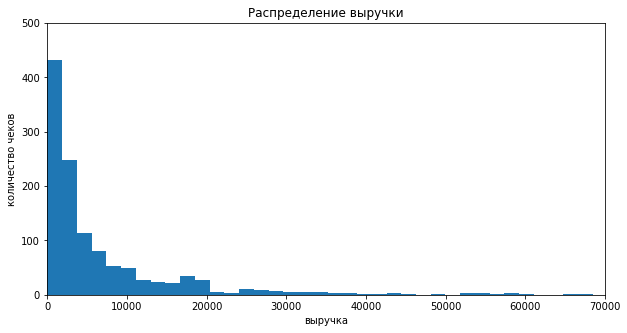

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(orders['revenue'], bins=700)
plt.axis([0, 70000, 0, 500])
plt.title('Распределение выручки')
plt.xlabel('выручка')
plt.ylabel('количество чеков')
plt.show()

заказы дороже 60 тыс. встречаются редко

In [7]:
columns=[orders['revenue'], visitors['visitors']]
alpha = 0.05

for column in columns:
    p_value=st.shapiro(column)[1]
    if p_value < alpha:
        print('Данные распределены ненормально')
    else:
        print('Данные распределены нормально')

Данные распределены ненормально
Данные распределены ненормально


данные по выручке и числу сессий в день распределены ненормально, поэтому при проверке гипотез будем использовать тест Манна-Уитни.

### графики кумулятивных метрик

создадим датасет с кумулятивными данными

In [8]:
# группы по уникальным датам
data_grouped = orders[['date', 'group']].drop_duplicates()
# накопление по заказам
orders_cumm=data_grouped.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'], orders['group']==x['group'])]\
                               .agg({'date':'max', 
                                     'group':'max', 
                                     'transactionId':pd.Series.nunique, 
                                     'visitorId': pd.Series.nunique, 
                                     'revenue':'sum'}), axis=1)\
.sort_values(by=['date', 'group']).reset_index(drop=True)
#display(orders_cumm.head())
# накопление по сессиям
visitors_cumm=data_grouped.apply(lambda x: visitors[np.logical_and(visitors['date']<=x['date'], visitors['group']==x['group'])]\
                                 .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)\
.sort_values(by=['date', 'group']).reset_index(drop=True)
#display(visitors_cumm.head())

# смерджим
data_cumm=orders_cumm.merge(visitors_cumm, on=['date', 'group'], how='left')
data_cumm=data_cumm.rename(columns={'transactionId':'orders', 'visitorId':'buyers'})
#добавим столбец с конверсией
#data_cumm['conversion']=data_cumm['buyers']/data_cumm['visitors']
display(data_cumm.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [9]:
# датасеты по группам
a_cumm = data_cumm[data_cumm['group']=='A']
b_cumm = data_cumm[data_cumm['group']=='B']

datas=[a_cumm, b_cumm]
for data in datas:
    #кумулятивный средний чек по группам;
    data['mean_revenue']=data['revenue']/data['orders']
    #кумулятивная конверсия по группам;
    data['conversion']=data['buyers']/data['visitors']

#относительное изменение кумулятивного среднего чека группы B к группе A;
ab_cumm = a_cumm.merge(b_cumm, on='date', how='left', suffixes=['_a', '_b'])
ab_cumm['mean_revenue_b_to_a'] = ab_cumm['mean_revenue_b']/ab_cumm['mean_revenue_a']
#относительное изменение кумулятивной конверсии группы B к группе A;
ab_cumm['conversion_b_to_a'] = ab_cumm['conversion_b']/ab_cumm['conversion_a']

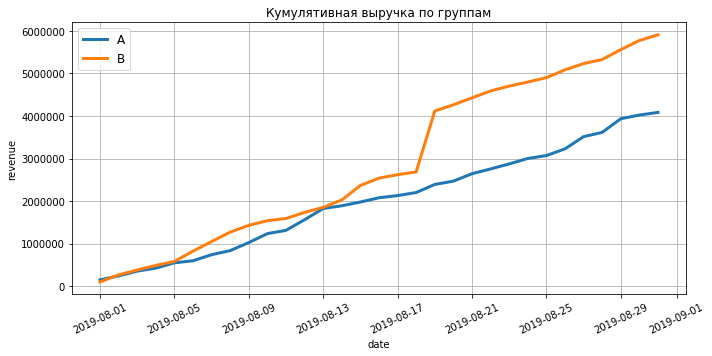

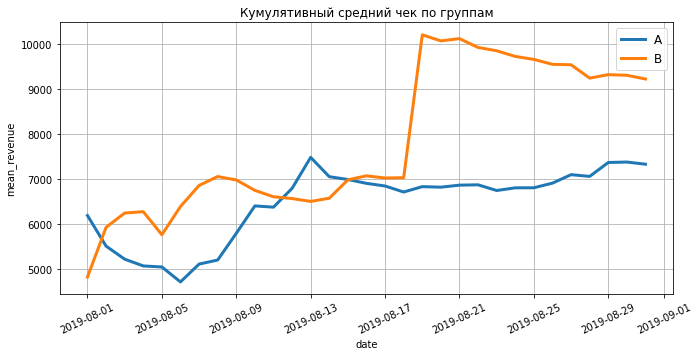

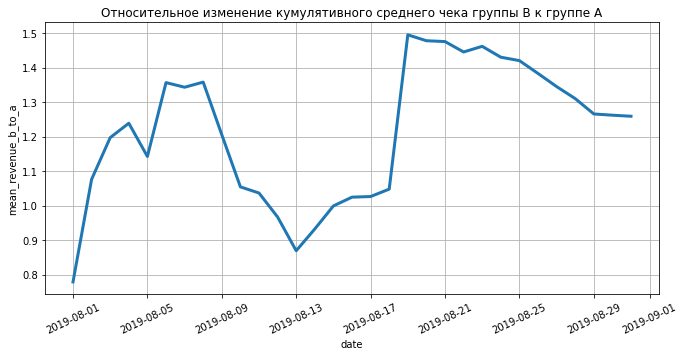

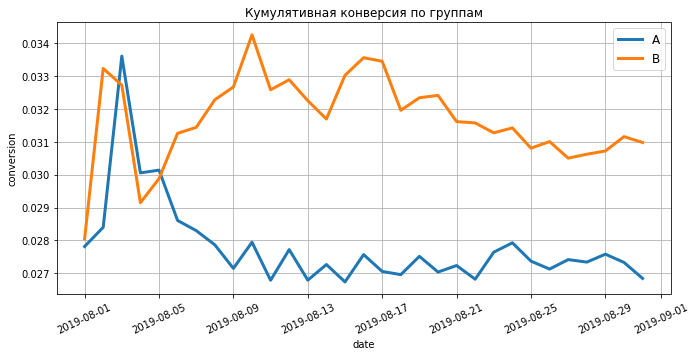

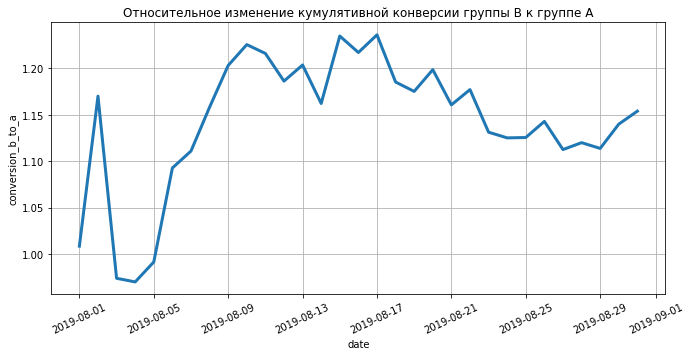

In [10]:
# функция литейного графика с 2 линиями
def two_lines(A, B, y, title):
    plt.figure(figsize=(11, 5))
    sns.lineplot(data=A, x='date', y=y, label='A', linewidth=3)
    sns.lineplot(data=B, x='date', y=y, label='B', linewidth=3)
    plt.xticks(rotation=25)
    plt.title(title)
    plt.grid()
    plt.legend(fontsize='large')
    plt.show()
    
# функция литейного графика с 1 линией
def line(df, col, title):
    plt.figure(figsize=(11, 5))
    sns.lineplot(data=df, x='date', y=col, linewidth=3)
    plt.xticks(rotation=25)
    plt.title(title)
    plt.grid()
    plt.show()

two_lines(a_cumm, b_cumm, 'revenue', 'Кумулятивная выручка по группам')
two_lines(a_cumm, b_cumm, 'mean_revenue', 'Кумулятивный средний чек по группам')
line(ab_cumm, 'mean_revenue_b_to_a', 'Относительное изменение кумулятивного среднего чека группы B к группе A')
two_lines(a_cumm, b_cumm, 'conversion', 'Кумулятивная конверсия по группам')
line(ab_cumm, 'conversion_b_to_a', 'Относительное изменение кумулятивной конверсии группы B к группе A')

- выручка растет равномерно на всем протяжении в обоих группах, что хорошо. но в группе В произошел всплеск выручки, причиной скорее всего стал экстримально дорогой заказ за 1,2 млн, т.к. график среднего чека также резко увеличился более чем на 3000.
- средний чек становится равномерным во 2 половине теста, в 1 половине ведет себя нестабильно, скорее всего из-за появления дорогих заказов.
- график изменения кумулятивного среднего чека сильно "скачет" 2, с 8 по 10 и 18 августа, там точно закрались выбросы.
- конверсия группы В больше А на, хотя и снижается во 2 половине теста. конверсия группы А стабильно колеблется вокруг 2,7%.
- конверсия группы В почти всегда больше, чем в группе А, только на 1 неделе она ниже. во второй половине разница конверсий снижается из-за снижение конверсии группы В.

построим точечный график выручки, чтобы определить границу выбросов. удалим строки с 2 самыми дорогими заказами для наглядности.

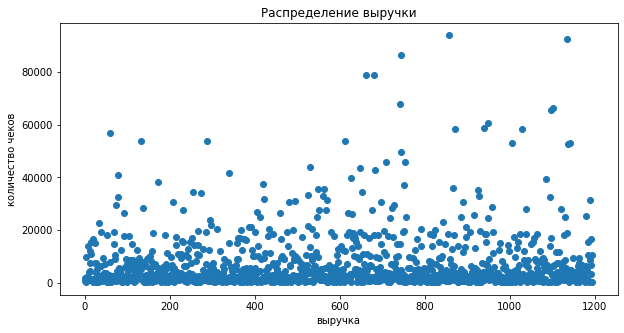

In [11]:
orders_without_blowout=orders[orders['revenue']<200000]

plt.figure(figsize=(10, 5))
x_values=pd.Series(range(0,len(orders_without_blowout['revenue'])))
plt.scatter(x_values, orders_without_blowout['revenue'])
plt.title('Распределение выручки')
plt.xlabel('выручка')
plt.ylabel('количество чеков')
plt.show()

заказы дороже 50 тыс. встречаются редко. найдем 95 и 99 перцентиль, чтобы точнее определить границу выбросов.

In [12]:
orders_percentile=np.percentile(orders['revenue'], [95, 99])
print(f'95 и 99 перцентили по заказам: {orders_percentile}')

95 и 99 перцентили по заказам: [28000.  58233.2]


удалим заказы дороже 50 тыс., таким образом уберем чуть больше 1%.

построим точечный график количества заказов по пользователям

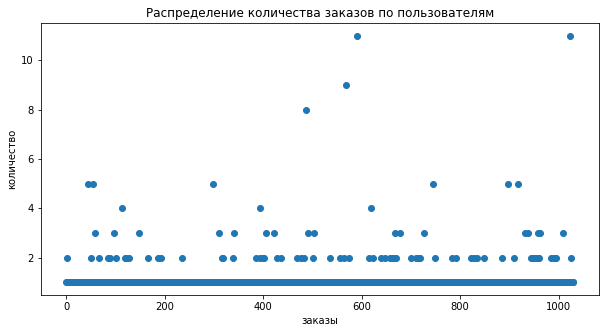

In [13]:
orders_per_buyer=orders.drop(['date', 'revenue', 'group'], axis=1)\
.groupby('visitorId').agg({'transactionId':pd.Series.nunique}).reset_index()
orders_per_buyer
plt.figure(figsize=(10, 5))
x_values=pd.Series(range(0,len(orders_per_buyer['visitorId'])))
plt.scatter(x_values, orders_per_buyer['transactionId'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('заказы')
plt.ylabel('количество')
plt.show()

In [14]:
buyers_percentile=np.percentile(orders_per_buyer['transactionId'], [95, 99])
print(f'95 и 99 перцентили по визитам: {buyers_percentile}')

95 и 99 перцентили по визитам: [2. 4.]


пользователи с 4 заказами и более редкость. удалим их как аномалии.

### проверка гипотез

проверим гипотезы методо Манна-Уитни т.к. данные распределены ненормально и имеют выбросы.

- Н0: конверсии между группами по «сырым» данным равны
- Н1: конверсии между группами по «сырым» данным отличаются

In [15]:
orders_a=orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
orders_b=orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})

orders_a.columns=['visitorId', 'order']
orders_b.columns=['visitorId', 'order']
# проставим посетителям, не сделавшим ни одного заказа 0 
sample_a=pd.concat([orders_a['order'], 
                    pd.Series(0, index=np.arange(ab_cumm['visitors_a'].sum()-len(orders_a['order'])), name ='order')], axis=0)

sample_b=pd.concat([orders_b['order'], 
                    pd.Series(0, index=np.arange(ab_cumm['visitors_a'].sum()-len(orders_b['order'])), name ='order')], axis=0)
# проверим статистическую значимость 
print('{:0.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))
# относительный прирост конверсии
print('{:0.3f}'.format(sample_b.mean()/sample_a.mean()-1))

0.006
0.149


p-знчение = 0.006, что значительно меньше 0.05, поэтому Н0 отвергаем, по "сырым" данным есть статистически значимые различия конверсий групп. относительный прирост конверсии в группе В = 14,9%

проверим статистическую значимость различий среднего чека.

- Н0: средний чек между группами по «сырым» данным равен
- Н1: средний чек между группами по «сырым» данным отличается

In [16]:
print('{:0.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{:0.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


p-знчение = 0.365, что больше 0.05, Н0 принимаем, по "сырым" данным нет статистически значимых различий среднего чека между группами. однако относительный выигрыш группы В = 25,9%, что довольно значительно, скорее всего вызвано аномально дорогими заказами в 1,2 млн и 200 тыс.

удалим аномалии и посчитаем статистическую значимость для "очищенных" данных.

- Н0: конверсии между группами по «очищенным» данным равны
- Н1: конверсии между группами по «очищенным» данным отличаются

In [17]:
# посетители c аномалиями
big_orders=orders[orders['revenue']>50000]['visitorId']
visitors_many_orders=pd.concat([orders_a[orders_a['order']>3]['visitorId'], 
                               orders_b[orders_b['order']>3]['visitorId']], axis=0)
# смерджим датасеты
clear_data=pd.concat([big_orders, visitors_many_orders], axis=0)\
.drop_duplicates()\
.sort_values()
print(f'всего пользователей с аномалиями: {clear_data.shape[0]}')
# данные по группам
clear_data_a=pd.concat(
    [orders_a[
        np.logical_not(orders_a['visitorId'].isin(clear_data))]['order'], 
     pd.Series(0, index=np.arange(ab_cumm['visitors_a'].sum()-len(orders_a['order'])), 
                                                     name='orders')], axis=0)
clear_data_b=pd.concat(
    [orders_b[
        np.logical_not(orders_b['visitorId'].isin(clear_data))]['order'], 
     pd.Series(0, index=np.arange(ab_cumm['visitors_a'].sum()-len(orders_b['order'])), 
                                                     name='orders')], axis=0)
# проверим статистическую значимость 
print('{:0.3f}'.format(st.mannwhitneyu(clear_data_a, clear_data_b)[1]))
# относительный прирост конверсии
print('{:0.3f}'.format(clear_data_b.mean()/clear_data_a.mean()-1))

всего пользователей с аномалиями: 26
0.004
0.170


p-знчение = 0.004, что меньше 0.05 и меньше p-значения "сырых" данных = 0.006, поэтому Н0 отвергаем, по "очищенным" данным есть статистически значимые различия конверсий групп. относительный прирост конверсии в группе В = 17%, в то время как по "сырым" данным прирост конверсии был 14,9%, что хорошо.

- Н0: средний чек между группами по «очищенным» данным равен
- Н1: средний чек между группами по «очищенным» данным отличается

In [18]:
# проверка статестической значимости
print('{:0.3f}'.format(
    st.mannwhitneyu(
        orders[np.logical_and(orders['group']=='A', 
                              np.logical_not(orders['visitorId'].isin(clear_data)))
                             ]['revenue'], 
               orders[np.logical_and(orders['group']=='B', 
                                     np.logical_not(orders['visitorId'].isin(clear_data)))
                                    ]['revenue'])[1]))
# отношение среднего чека
print('{:0.3f}'.format(orders[np.logical_and(orders['group']=='B', 
                                             np.logical_not(orders['visitorId'].isin(clear_data)))]['revenue'].mean()/
                       orders[np.logical_and(orders['group']=='A', 
                                             np.logical_not(orders['visitorId'].isin(clear_data)))]['revenue'].mean()-1))

0.409
0.024


p-знчение = 0.409, значительно больше 0.05, Н0 принимаем, по "очищенным" данным нет статистически значимых различий среднего чека между группами. относительный прирост среднего чека для группы В относительно А снизился с 25.9% для "сырых" данных до 2.4% для "очищенных". это вызвано очисткой данных от аномально дорогих заказов.

## Вывод

- как по "сырым", так и по "очищенным" данным есть статистически значимые различия конверсий групп. относительный прирост конверсии в группе В = 17%, что довольно большое значение.
- по "сырым" и "очищенным" данным нет статистически значимых различий среднего чека между группами. 
- по графикам кумулятивной конверсии видно, что для группы B она стабильно больше, чем в группе А, хотя и имеет тенденцию к медленному снижению во 2 половине теста.
- прирост среднего чека для группы В вызван всплесками аномально дорогих заказов, без них различийй в средних чеках нет.
- тест можно признать успешным, группа В значительно лучше, чем А по конверсии, хотя средние чеки равны.